# Introduction

This is an implementation for Sequence to Sequence Encoder - Decoder Model (with Attention) using GRU trained for the task of News Summarisation. It is based on the paper - [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). Refer [notebook](https://github.com/abhishekanand1710/Seq2Seq-EncoderDecoder/blob/main/Seq2Seq-2-RNN-Encoder-Decoder-Attention.ipynb) for more details and explanation.

It is implemented as an excerise to gain a deeper understanding of Encoder - Decoder models and build on it to explore advancements on the same.

Dataset used - [CNN-dailymail](https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail)

In [1]:
import numpy as np
import pandas as pd
import spacy
from tqdm import tqdm


from string import digits
import random
from torchtext.data.utils import get_tokenizer
import torch
import torchtext
from collections import Counter
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
torch.cuda.empty_cache()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import math
import time
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv


In [2]:
SEED = 97

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
df_train = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv").drop(columns="id")
df_test = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv").drop(columns="id")
df_valid = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv").drop(columns="id")

In [4]:
df_train = df_train.dropna().drop_duplicates().reset_index()
df_valid = df_valid.dropna().drop_duplicates().reset_index()
df_test = df_test.dropna().drop_duplicates().reset_index()

In [5]:
len(df_train), len(df_test), len(df_valid)

(284015, 11488, 13368)

In [6]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [7]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [8]:
tokenizer = get_tokenizer('spacy', language='en_core_web_lg')

<AxesSubplot:>

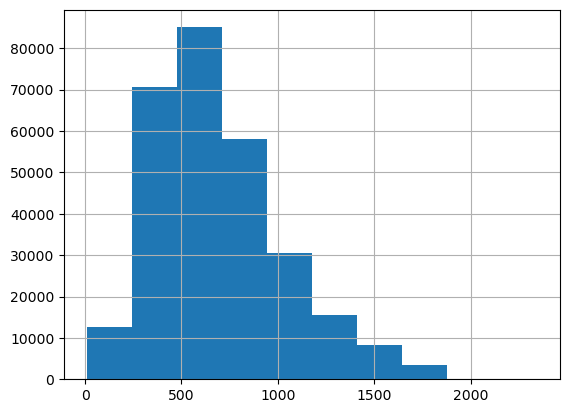

In [9]:
df_train['article'].map(lambda x: len(x.split(' '))).hist()

<AxesSubplot:>

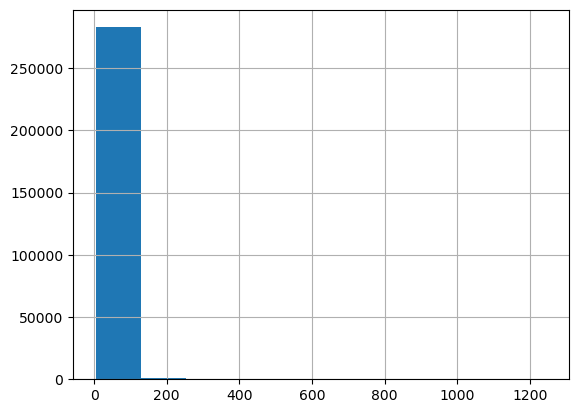

In [10]:
df_train['highlights'].map(lambda x: len(x.split(' '))).hist()

In [11]:
MAX_ARTICLE_LEN=1024
MAX_HIGHLIGHT_LEN=256

In [12]:
check_len_article = lambda x: len(x.split(' ')) > MAX_ARTICLE_LEN
check_len_highlight = lambda x: len(x.split(' ')) > MAX_HIGHLIGHT_LEN

In [13]:
df_train = df_train.drop(df_train[df_train.article.apply(check_len_article) | df_train.highlights.apply(check_len_highlight)].index)
df_valid = df_valid.drop(df_valid[df_valid.article.apply(check_len_article) | df_valid.highlights.apply(check_len_highlight)].index)
len(df_train), len(df_valid)

(239229, 11283)

In [14]:
df_train.head()

,index,article,highlights
0,0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [15]:
df_train = df_train.drop(['index'], axis=1)
df_valid = df_valid.drop(['index'], axis=1)
df_test = df_test.drop(['index'], axis=1)

In [16]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
        
    return text

In [17]:
def clean_data(data):
    clean_data = []
    pairs = data.values.tolist()
    for (article, highlight) in tqdm(pairs):
        #clean_data.append([clean_text(article, remove_stopwords=False), clean_text(highlight, remove_stopwords=False)])
        clean_data.append([article, highlight])
    
    return clean_data

In [18]:
train_pairs = clean_data(df_train.iloc[:100000])
valid_pairs = clean_data(df_valid)
test_pairs = clean_data(df_test)

100%|██████████| 11488/11488 [00:00<00:00, 39027.08it/s]


In [19]:
def build_vocab(data, tokenizer):
    article_counter = Counter()
    highlight_counter = Counter()
    for (article, highlight) in tqdm(data):
        article_counter.update(tokenizer(article))
        highlight_counter.update(tokenizer(highlight))
    return vocab(article_counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=5), vocab(highlight_counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=5)

In [20]:
articles_vocab, highlights_vocab = build_vocab(train_pairs, tokenizer)
len(articles_vocab), len(highlights_vocab)

100%|██████████| 100000/100000 [03:02<00:00, 548.68it/s]


(125012, 37493)

In [21]:
articles_vocab.set_default_index(articles_vocab['<unk>'])
highlights_vocab.set_default_index(highlights_vocab['<unk>'])

In [22]:
def data_process(data):
    pairs = []
    for (article, highlight) in tqdm(data):
        article_tensor = torch.tensor([articles_vocab[token] for token in tokenizer(article)],
                            dtype=torch.long)
        highlight_tensor = torch.tensor([highlights_vocab[token] for token in tokenizer(highlight)],
                            dtype=torch.long)
        pairs.append((article_tensor, highlight_tensor))
    return pairs

In [23]:
train_data = data_process(train_pairs)
val_data = data_process(valid_pairs)
test_data = data_process(test_pairs)

100%|██████████| 11488/11488 [00:26<00:00, 430.28it/s]


In [24]:
del df_train
del df_valid
del df_test
del train_pairs
del valid_pairs
del test_pairs

In [25]:
len(train_data), len(val_data)

(100000, 11283)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 8
PAD_IDX = articles_vocab['<pad>']
BOS_IDX = articles_vocab['<bos>']
EOS_IDX = articles_vocab['<eos>']

In [27]:
def generate_batch(data_batch):
    article_batch, highlight_batch = [], []
    for (article, highlight) in data_batch:
        article_batch.append(torch.cat([torch.tensor([BOS_IDX]), article, torch.tensor([EOS_IDX])], dim=0).to(device))
        highlight_batch.append(torch.cat([torch.tensor([BOS_IDX]), highlight, torch.tensor([EOS_IDX])], dim=0).to(device))  
        
    article_batch = pad_sequence(article_batch, padding_value=PAD_IDX)
    highlight_batch = pad_sequence(highlight_batch, padding_value=PAD_IDX)
    return article_batch, highlight_batch

In [28]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)

In [29]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 emb_dim: int, 
                 enc_hid_dim: int, 
                 dec_hid_dim: int, 
                 dropout: float):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.gru = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        outputs, hidden = self.gru(embedded)
                
        #outputs = [src sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        # Note: torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        # is of shape [batch_size, enc_hid_dim * 2]
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [30]:
class Attention(nn.Module):
    def __init__(self, 
                 enc_hid_dim: int, 
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim
        
        self.attn = nn.Linear(self.attn_in, attn_dim)
        self.v = nn.Parameter(torch.rand(attn_dim))
        
    def forward(self, decoder_hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #decoder_hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        # Step 1: to enable feeding through "self.attn" pink box above, concatenate 
        # `repeated_decoder_hidden` and `encoder_outputs`:
        # torch.cat((hidden, encoder_outputs), dim = 2) has shape 
        # [batch_size, seq_len, enc_hid_dim * 2 + dec_hid_dim]
        
        # Step 2: feed through self.attn to end up with:
        # [batch_size, seq_len, attn_dim]
        
        # Step 3: feed through tanh       
        
        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden, 
            encoder_outputs), 
            dim = 2))) 
        
        #energy = [batch size, src sent len, attn_dim]
        
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, attn_dim, src sent len]
        
        #v = [attn_dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, attn_dim]
        
        # High level: energy a function of both encoder element outputs and most recent decoder hidden state,
        # of shape attn_dim x enc_seq_len for each observation
        # v, being 1 x attn_dim, transforms this into a vector of shape 1 x enc_seq_len for each observation
        # Then, we take the softmax over these to get the output of the attention function

        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention= [batch size, src len]
        
        return torch.nn.functional.softmax(attention, dim=1)

In [31]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim: int, 
                 emb_dim: int, 
                 enc_hid_dim: int, 
                 dec_hid_dim: int, 
                 dropout: int, 
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        # Note: from Attention: self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, attn_dim)
        
        # Note: `output_dim` same as `vocab_size`
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.gru = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def _weighted_encoder_rep(self, decoder_hidden, encoder_outputs):
        
        # Attention, at a high level, takes in:
        # The decoder hidden state
        # All the "seq_len" encoder outputs
        # Outputs a vector summing to 1 of length seq_len for each observation
        a = self.attention(decoder_hidden, encoder_outputs)

        #a = [batch size, src len]

        a = a.unsqueeze(1)

        #a = [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        #weighted_encoder_rep = [batch size, 1, enc hid dim * 2]

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        #weighted_encoder_rep = [1, batch size, enc hid dim * 2]
        
        return weighted_encoder_rep
        
        
    def forward(self, input, decoder_hidden, encoder_outputs):
             
        #input = [batch size] Note: "one character at a time"
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden, 
                                                          encoder_outputs)
        
        # Then, the input to the decoder _for this character_ is a concatenation of:
        # This weighted attention
        # The embedding itself
        
        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, decoder_hidden = self.gru(rnn_input, decoder_hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #decoder_hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == decoder_hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)
        
        output = self.out(torch.cat((output, 
                                     weighted_encoder_rep, 
                                     embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, decoder_hidden.squeeze(0)

In [32]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder: nn.Module, 
                 decoder: nn.Module, 
                 device: torch.device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, 
                teacher_forcing_ratio: float = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs

In [33]:
INPUT_DIM = len(articles_vocab)
OUTPUT_DIM = len(highlights_vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ATTN_DIM = 32
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [34]:
OUTPUT_DIM

37493

In [35]:
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(125012, 128)
    (gru): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=32, bias=True)
    )
    (embedding): Embedding(37493, 128)
    (gru): GRU(640, 256)
    (out): Linear(in_features=896, out_features=37493, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [36]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 55,870,389 trainable parameters


In [37]:
optimizer = optim.Adam(model.parameters())

In [38]:
PAD_IDX = highlights_vocab['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [39]:
def train(model, dataloader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for _, (src, trg) in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / (len(dataloader)*BATCH_SIZE)

In [40]:
def evaluate(model, dataloader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for _, (src, trg) in enumerate(tqdm(dataloader)):
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / (len(dataloader)*BATCH_SIZE)

In [41]:
def epoch_time(start_time: int, 
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
MODEL_PATH = 'rnn-attn-model.pt'

In [43]:
N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_PATH)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 1411/1411 [05:22<00:00,  4.38it/s]


Epoch: 01 | Time: 128m 15s
	Train Loss: 0.769 | Train PPL:   2.158
	 Val. Loss: 0.830 |  Val. PPL:   2.293


100%|██████████| 1411/1411 [05:24<00:00,  4.35it/s]


Epoch: 02 | Time: 128m 16s
	Train Loss: 0.695 | Train PPL:   2.004
	 Val. Loss: 0.822 |  Val. PPL:   2.274


100%|██████████| 1411/1411 [05:27<00:00,  4.31it/s]


Epoch: 03 | Time: 128m 56s
	Train Loss: 0.664 | Train PPL:   1.942
	 Val. Loss: 0.815 |  Val. PPL:   2.259


In [44]:
model.load_state_dict(torch.load(MODEL_PATH))
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

100%|██████████| 1436/1436 [06:16<00:00,  3.82it/s]

| Test Loss: 0.818 | Test PPL:   2.267 |


In [45]:
df_test = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv").drop(columns="id")
df_test

,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."
...,...,...
11485,Our young Earth may have collided with a body ...,Oxford scientists say a Mercury-like body stru...
11486,A man facing trial for helping his former love...,Man accused of helping former lover kill woman...
11487,A dozen or more metal implements are arranged ...,Marianne Power tried the tuning fork facial at...
11488,Brook Lopez dominated twin brother Robin with ...,Brooklyn Nets beat the Portland Trail Blazers ...


In [46]:
test_article = "A 26-year-old man was hacked to death by his relatives over a trivial row on car parking in Medimallasandra near Hoskote. The incident happened on Sunday. The deceased has been identified as Ismail Khan, while the accused are on the run.According to the police, the deceased and the accused had a property dispute for a long time. On Sunday, a heated argument ensued over car parking. In the melee, the accused stabbed Ismail repeatedly, killing him on the spot. The accused soon fled the scene.The Anugondanahalli police rushed to the spot and conducted spot inspection before shifting the body for post-mortem. The police have registered a case of murder and efforts are on to track down the accused."
test_text_cleaned = clean_text(test_article)
test_text_cleaned

'26 year old man hacked death relatives trivial row car parking medimallasandra near hoskote incident happened sunday deceased identified ismail khan accused run according police deceased accused property dispute long time sunday heated argument ensued car parking melee accused stabbed ismail repeatedly killing spot accused soon fled scene anugondanahalli police rushed spot conducted spot inspection shifting body post mortem police registered case murder efforts track accused'

In [47]:
test_article_tensor = torch.tensor([[articles_vocab[token] for token in tokenizer(test_text_cleaned)]],
                            dtype=torch.long, device=device)
test_article_tensor

tensor([[ 4732,   149,   150,  2528,  8439,   390,  5149, 18722,  2914,   361,
          6464,     0,   489,     0,  1418,  1719, 79258, 22771,  1951,     0,
             0,  1079,   647,   210,   182, 22771,  1079,   303,  2677,   515,
            91, 79258, 11918,  3404, 34582,   361,  6464, 33617,  1079,  4428,
             0, 12839,  2737,  2426,  1079,  2953,  2788,  2701,     0,   182,
           618,  2426,  2705,  2426,  5295,  2217,  2707,   777,  6283,   182,
         10591,   555,   159,  4710,  6172,  1079]], device='cuda:0')

In [48]:
decoder_start_tensor = torch.tensor([[highlights_vocab['<bos>']]], device=device)
decoder_start_tensor = decoder_start_tensor.repeat(1, 20)
decoder_start_tensor

tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]],
       device='cuda:0')

In [49]:
test_article_tensor.size(), decoder_start_tensor.size()

(torch.Size([1, 66]), torch.Size([1, 20]))

In [50]:
test_article_tensor = test_article_tensor.permute(1, 0)
decoder_start_tensor = decoder_start_tensor.permute(1, 0)
test_article_tensor.size(), decoder_start_tensor.size()

(torch.Size([66, 1]), torch.Size([20, 1]))

In [51]:
output = model(test_article_tensor, decoder_start_tensor, 0) #turn off teacher forcing

In [52]:
output

tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[  9.6117,  -9.2277,  -9.4205,  ...,  -5.1524,  -6.1402,  -7.6929]],

        [[  6.1524,  -9.5750,  -9.4754,  ...,  -7.1218,  -7.8977,  -7.9713]],

        ...,

        [[  6.6979, -11.7689, -11.9391,  ...,  -6.8066,  -9.2914, -10.4182]],

        [[  6.1478, -12.9811, -13.2385,  ...,  -8.7629, -10.3118, -11.3260]],

        [[  6.7741, -12.8686, -13.0602,  ...,  -7.3682, -10.0626, -11.3152]]],
       device='cuda:0', grad_fn=<CopySlices>)

In [53]:
output.size()

torch.Size([20, 1, 37493])

In [54]:
output = output.squeeze(1)

In [55]:
output.size()

torch.Size([20, 37493])

In [56]:
decoded_words = []
itos = highlights_vocab.get_itos()
for ot in range(output.size(0)):
    topv, topi = output[ot].topk(1)
    #print(topi)
    decoded_words.append(itos[topi[0].item()])

In [57]:
decoded_words

['<unk>',
 'Police',
 'officer',
 'accused',
 'of',
 'racial',
 'slur',
 'outside',
 'the',
 'scene',
 '.',
 '\n',
 'Police',
 'allegedly',
 'racially',
 'assaulted',
 'the',
 'scene',
 'of',
 'the']